## Advanced Lane Finding Notebook ##
This project calibrates images from a vehicles central camera for use in detecting lanes.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

### Camera Calibration ###
Prior to executing the lane finding pipeline, the camera must be calibrated using 9x6 chessboard images.  This is only completed once.

_Globals and Functions for calibration:_

In [2]:
nx = 9
ny = 6

worldPoints = []
worldPt = np.zeros((nx*ny,3), np.float32)
worldPt[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) 

imagePoints = []

def findChessboardPoints(fname):
    # Find the chessboard corners of file.
    iRGB = mpimg.imread(fname)
    
    # Search for the image chessboard points
    gray = cv2.cvtColor(iRGB, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # Store the points if found
    if ret == True:
        worldPoints.append(worldPt)
        imagePoints.append(corners)
        iRGB = cv2.drawChessboardCorners(iRGB, (nx,ny), corners, ret)
    return iRGB

_Testing Cell:_

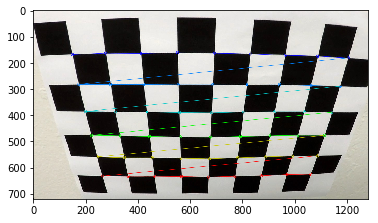

In [3]:
iRGB = findChessboardPoints('camera_cal/calibration2.jpg')
plt.imshow(iRGB)

Process all the provided calibration images:

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')
for chessboard in images:
    findChessboardPoints(chessboard)

print("Calibration points found in {} of {} images".
      format(len(imagePoints), len(images)))

Calibration points found = 18 of 1080 possible


### Lane Finding Pipeline ###
1. Distortion correction
2. Binary image threshold creation
3. Perspective transformation
4. Lane line identification
5. Curvature and location estimation

#### Distortion Correction ####

#### Binary Image Threshold Creation ####
The following functions are potentially used by the pipeline to create filtered binary images.  

In [ ]:
def apply_thresh(binary, thresh=(0, 255)):
    # Apply the threshold
    binary_th = np.zeros_like(binary)
    binary_th[(binary >= thresh[0]) & (binary <= thresh[1])] = 1
    return binary_th

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate the directional gradient
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return apply_thresh(scaled_sobel, thresh)

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    return apply_thresh(scaled_sobel, thresh)

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    return apply_thresh(dir_sobel, thresh)

def s_color_threshold(img, thresh=(0, 255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    return apply_thresh(s_channel, thresh)

_Ploting Functions for binary threshold calculations_

In [ ]:
def plot_sobel_binary(image, binary, binaryTitle):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax2.imshow(binary, cmap='gray')
    ax2.set_title(binaryTitle)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.tight_layout()
    plt.show()
    return

def plot_sobel_binaries(gradx, grady, mag_binary, dir_binary):
    f, axes = plt.subplots(2, 2, figsize=(16, 6))
    f.tight_layout()
    axes[0,0].imshow(gradx, cmap='gray')
    axes[0,1].imshow(grady, cmap='gray')
    axes[1,0].imshow(mag_binary, cmap='gray')
    axes[1,1].imshow(dir_binary, cmap='gray')
    plt.tight_layout()
    plt.show()
    return

def plot_combined_binaries(sobel_binary, color_binary, combined_binary):
    # Stack each channel to view contributions
    stacked_binary = np.dstack((np.zeros_like(sobel_binary), 
                                sobel_binary, 
                                color_binary))

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(stacked_binary)

    ax2.set_title('Combined color channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    plt.show()

#### Perspective Transformation ####

#### Lane Line Identification ####

#### Curvature and Location Estimation ####